In [336]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime

In [337]:
url = 'https://www.cdc.gov/coronavirus/2019-ncov/cases-in-us.html'

### Extract date

In [338]:
content = requests.get(url).content
soup =BeautifulSoup(content, 'lxml')

In [339]:
data = soup.findAll(text=re.compile("Updated .+ 202\d"))
data

['Updated January 31, 2020']

In [340]:
m = re.search("Updated (\w+ \d+, 202\d)", data[0])
data_date_str = m.group(1)
data_date = datetime.strptime(data_date_str, '%B %d, %Y').strftime('%Y-%m-%d')
data_date

'2020-01-31'

### Extract data and add into Dataframe

In [368]:
dfs = pd.read_html(url)

In [369]:
if len(dfs) == 0 :
    raise Exception('There is no dataframes detected')

In [370]:
df = dfs[0]
df

,0,1
0,Positive,6
1,Negative,114
2,Pending§,121
3,Total,241


In [371]:
df = df.set_index(0).T
df

,Positive,Negative,Pending§,Total
1,6,114,121,241


In [372]:
# remove non alphanumeric characters from the columns
# also lowercase them
df.columns = df.columns.map(lambda x: re.sub('\W+', '', str.lower(x)))

# add column date to the front
df.insert(0, 'date', data_date)


In [373]:
df

,date,positive,negative,pending,total
1,2020-01-31,6,114,121,241


### Save to file

In [374]:
from pathlib import Path
csv_file = 'data/cdc-us-cases.csv'

if Path(csv_file).exists():
    # read out the old dat
    old_df = pd.read_csv(csv_file)
    df = df.append(old_df)
df.drop_duplicates(subset=['date'], inplace=True)

In [375]:
df.sort_values(by=['date'], inplace=True)
df
df.to_csv(csv_file, index=False)

### Plot graph

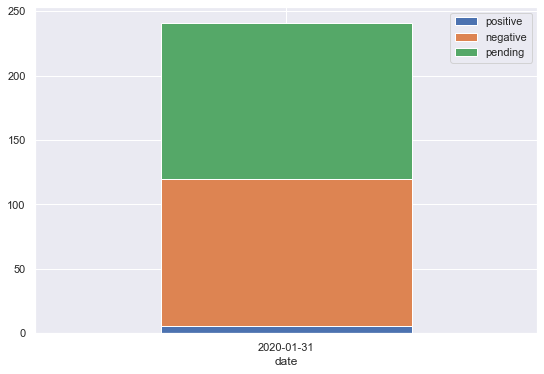

In [405]:

png_file = 'images/cdc-us-cases.png'

ax = df.drop(['total'], axis=1).set_index('date').plot(kind='bar', 
                                                       stacked=True, 
                                                       figsize=(9,6))
l = ax.legend()

for label in ax.get_xticklabels():
    label.set_rotation(0) 

In [406]:
fig = ax.get_figure()
fig.savefig(png_file)